In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
from sqlalchemy import inspect
#date = dt.datetime(2011, 5, 31)
inspector = inspect(engine)
for column in inspector.get_columns('Measurement'):
    print(f"{column['name']}, {column['type']}")
    


id, INTEGER
station, TEXT
date, TEXT
prcp, FLOAT
tobs, FLOAT


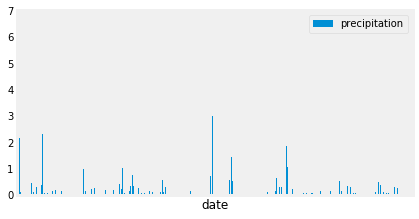

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
maxDate = session.query( func.max(Measurement.date).label('maxdate')).all()
maxDate = list(np.ravel(maxDate))

maxDate=pd.to_datetime(maxDate[0])

minDate = maxDate- relativedelta.relativedelta(months=12)
#minDate = maxDate- dt.timedelta(weeks=52)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date , Measurement.prcp).filter( Measurement.date >= minDate.date()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'prcp'])
df = df.rename(columns = {'prcp':'precipitation'})
df.set_index('date',inplace=True)

# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.bar()
plt.tight_layout()
plt.tick_params(axis='x',  which='both', bottom=False, top=False, labelbottom=False) 
plt.grid()
plt.show()



![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?

numOfStations = session.query(Measurement.station).distinct(Measurement.station).group_by(Measurement.station).count()
print(f'Number of stations: {numOfStations}')

Number of stations: 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
results = session.query(Measurement.station, func.min(Measurement.prcp).label("low"), func.max(Measurement.prcp).label("high"), func.avg(Measurement.prcp).label("avg")).\
    filter(Measurement.station=='USC00519281').\
    group_by(Measurement.station).all()
df = pd.DataFrame(results)
#print(df.loc[0,'station'])
print(f"Station {df.loc[0,'station']}: Lowest temperature- {df.loc[0,'low']}, Highest Temperature-{df.loc[0,'high']} & Average Temperature-{df.loc[0,'avg']}")

Station USC00519281: Lowest temperature- 0.0, Highest Temperature-9.64 & Average Temperature-0.2123520923520915


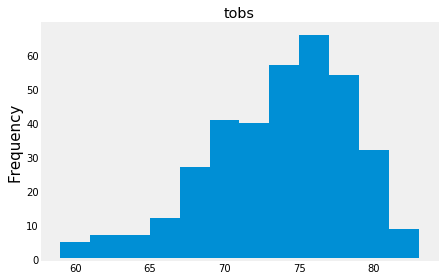

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#get station with the highest number of temp observations
result = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(desc(func.count(Measurement.tobs))).limit(1).all()

stationHighNumTemp = list(np.ravel(result))[0]                   

#get max date for the station
maxDate = session.query( func.max(Measurement.date)).filter(Measurement.station==stationHighNumTemp).all()

maxDate = list(np.ravel(maxDate))

maxDate=pd.to_datetime(maxDate[0])

#...and the min date for the station
minDate = maxDate - relativedelta.relativedelta(months=12)

# retrieve prcp for the station for the past 12mths
results = session.query(Measurement.tobs).filter( Measurement.date >= minDate.date()).\
    filter(Measurement.station == stationHighNumTemp).all()

df = pd.DataFrame(results, columns=['tobs'])

# Use Pandas Plotting with Matplotlib to plot the data
df.hist(column='tobs', bins=12)
plt.tight_layout()
plt.ylabel("Frequency",fontsize=15)
plt.grid()
plt.show()


![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_temp_tuple = calc_temps('2016-10-10','2016-10-20')

trip_temp = [list(np.ravel(trip_temp_tuple))[0], list(np.ravel(trip_temp_tuple))[1], list(np.ravel(trip_temp_tuple))[2]]

print(f'Min temperature: {trip_temp[0]}, Avg temperature: {trip_temp[1]}, Max temperature: {trip_temp[2]}')

Min temperature: 70.0, Avg temperature: 77.68571428571428, Max temperature: 81.0


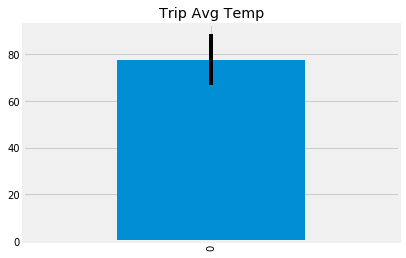

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df = pd.DataFrame(trip_temp)

df.iloc[1].plot(kind="bar", title="Trip Avg Temp", yerr= trip_temp[2]-trip_temp[0])

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

prcp_stats = session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.date >= '2016-10-10').filter(Measurement.date <= '2016-10-20').\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    order_by(desc(func.sum(Measurement.prcp))).all()

pd.DataFrame(prcp_stats, columns=["Station", "Total Precipitation", "Name","Latitude","Longitude","Elevation"])

,Station,Total Precipitation,Name,Latitude,Longitude,Elevation
0,USC00516128,2.62,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,0.49,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,0.19,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,0.14,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,0.12,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,0.01,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,NaN,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
